In [159]:
import curr_adventure as cad 
import jax.numpy as jnp
from jax import random as jrandom
from jax import jit, partial, grad, jacfwd


from curr_adventure.derivative_estimation.one_E_zero import SD_1E0
from utils import run_tests, mse_loss

from scipy.stats import linregress
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm 

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

from jax.config import config
config.update("jax_enable_x64", True)

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
barrier_multiplier = 5

def LogPolytopeGetter(dim, noise=0):
    jrandom_key = jrandom.PRNGKey(0)
    b = jnp.ones(dim*barrier_multiplier)
    jrandom_key, subkey = jrandom.split(jrandom_key)
    ws = jrandom.normal(subkey, shape=(dim*barrier_multiplier, dim,)).dot(jnp.diag(jnp.linspace(0.1, 5, dim)))
    ws /= jnp.linalg.norm(ws, axis=1).reshape(-1, 1)
    jrandom_key, subkey = jrandom.split(jrandom_key)
    A = jrandom.normal(subkey, shape=(dim, dim))
    U, _, _ = jnp.linalg.svd(A) # some rotation matrix
    S = jnp.diag(jnp.linspace(0.1, 5, dim)) # the axis scaling
    U = jnp.array([[-0.63746552,  0.77047888],
             [ 0.77047888,  0.63746552]])
    S = jnp.array([[0.1, 0. ],
             [0. , 5. ]])
    ws = ws.dot(S.dot(U.T))
    return cad.Barriers.LogPolytopeBarrier(ws, b, noise)

class Ackley:
    def __init__(self, noise_std=0):
        if noise_std is None:
            noise_std = 0
        self.noise_std = noise_std
    
    def f(self, X, jrandom_key=None):
        xs = X.T
        out_shape = xs[0].shape
        a = jnp.exp(-0.2 * jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0))))
        b = - jnp.exp(1. / len(xs) *jnp.sum(jnp.cos(2 * jnp.pi * xs), axis=0))
        out = jnp.array(-20 * a + b + 20 + jnp.exp(1)).reshape(out_shape)
        if jrandom_key is not None:
            return out + self.noise_std * jrandom.normal(jrandom_key, shape=(X.shape[0], )) 
        return out


    def f1(self, X):
        """del H/del xi = -20 * -0.2 * (xi * 1/n) / sqrt(1/n sum_j xj^2) * a + 2 pi sin(2 pi xi)/n * b"""
        xs = X.T
        out_shape = xs.shape
        a = jnp.exp(-0.2 * jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0))))
        b = -jnp.exp(1. / len(xs) * jnp.sum(jnp.cos(2 * jnp.pi * xs), axis=0))
        a_p = -0.2 * (xs * 1. / len(xs)) / jnp.sqrt(1. / len(xs) * jnp.square(jnp.linalg.norm(xs, axis=0)))
        b_p = -2 * jnp.pi * jnp.sin(2 * jnp.pi * xs) / len(xs)
        grad = jnp.nan_to_num(
            -20 * a_p * a + b_p * b).reshape(out_shape)  # only when norm(x) == 0 do we have nan and we know the grad is zero there
        grad = grad.T
        
        return grad

    def f2(self, X):
        return jacfwd(lambda x: self.f1(x))(X).reshape(X.shape[0], X.shape[1], X.shape[1])


funcs = {
#     "LogPolytope": lambda dim: LogPolytopeGetter(dim, 0.05),
    "Ackley": lambda dim: Ackley(0.1)
}

def config_creator(F, x_0, h, num_samples, hessian_geometry):
    config = {}
    config["N"] = num_samples
    config["h"] = h
    if hessian_geometry:
        config["ellipse_M"] = jnp.linalg.inv(F.f2(x_0.reshape(1, -1))[0])
#         print(F.f2(x_0.reshape(1, -1)))
        print(jnp.linalg.eig(config["ellipse_M"]))
    else:
        config["ellipse_M"] = jnp.eye(x_0.shape[0])


    config["sample_subspace_basis"] = None
    config["F"] = F
#     config["distribution_name"] = "beta"
    config["is_uniform_sphere_random"] = False
    return config
    

fd_estimator = lambda F, x_0, h, num_samples, subkey: SD_1E0(F, x_0, config_creator(F, x_0, h, num_samples, False), subkey, sample_based=True)
sd_estimator = lambda F, x_0, h, num_samples, subkey: SD_1E0(F, x_0, config_creator(F, x_0, h, num_samples, True), subkey, sample_based=True)




seed = 0

standard_deviations = list(jnp.logspace(1.2, -5, 50)) # [100, 10, 1, 0.25, 0.1] 
dimensions = [2] # jnp.linspace(10, 200, 11, dtype=int) # [10] # [100] #






In [206]:
FD_logs = []
SD_logs = []
SSD_logs = []
x = 12
x_0_generator = lambda dim: x*jnp.ones(dim)/jnp.linalg.norm(jnp.ones(dim))

frac_samples = [2] # list(jnp.logspace(0.1, 1.5, 3))
num_runs = 1

FD_logs = run_tests(fd_estimator, funcs, x_0_generator, standard_deviations, dimensions, frac_samples, num_runs, seed, loss_type="MSE")
 
SD_logs = run_tests(sd_estimator, funcs, x_0_generator, standard_deviations, dimensions, frac_samples, num_runs, seed, loss_type="MSE")
    

  0%|          | 0/1 [00:00<?, ?it/s]

[DeviceArray([-0.13518875+0.j, -0.13853492+0.j], dtype=complex128), DeviceArray([[ 0.70710678+0.j, -0.70710678+0.j],
             [ 0.70710678+0.j,  0.70710678+0.j]], dtype=complex128)]
[DeviceArray([-0.13518875+0.j, -0.13853492+0.j], dtype=complex128), DeviceArray([[ 0.70710678+0.j, -0.70710678+0.j],
             [ 0.70710678+0.j,  0.70710678+0.j]], dtype=complex128)]
[DeviceArray([-0.13518875+0.j, -0.13853492+0.j], dtype=complex128), DeviceArray([[ 0.70710678+0.j, -0.70710678+0.j],
             [ 0.70710678+0.j,  0.70710678+0.j]], dtype=complex128)]
[DeviceArray([-0.13518875+0.j, -0.13853492+0.j], dtype=complex128), DeviceArray([[ 0.70710678+0.j, -0.70710678+0.j],
             [ 0.70710678+0.j,  0.70710678+0.j]], dtype=complex128)]
[DeviceArray([-0.13518875+0.j, -0.13853492+0.j], dtype=complex128), DeviceArray([[ 0.70710678+0.j, -0.70710678+0.j],
             [ 0.70710678+0.j,  0.70710678+0.j]], dtype=complex128)]
[DeviceArray([-0.13518875+0.j, -0.13853492+0.j], dtype=complex128), De

KeyboardInterrupt: 

In [170]:
SD_means

loss_approx
function dimension std       frac_samples             
Ackley   2         0.000010  2                     NaN
                   0.000013  2                     NaN
                   0.000018  2                     NaN
                   0.000024  2                     NaN
                   0.000032  2                     NaN
                   0.000043  2                     NaN
                   0.000057  2                     NaN
                   0.000077  2                     NaN
                   0.000103  2                     NaN
                   0.000138  2                     NaN
                   0.000184  2                     NaN
                   0.000247  2                     NaN
                   0.000330  2                     NaN
                   0.000441  2                     NaN
                   0.000591  2                     NaN
                   0.000791  2                     NaN
                   0.001058  2                     NaN
                   0.001416  2                     NaN
                   0.001895  2                     NaN
                   0.002536  2                     NaN
                   0.003393  2                     NaN
                   0.004541  2                     NaN
                   0.006077  2                     NaN
                   0.008132  2                     NaN
                   0.010883  2                     NaN
                   0.014563  2                     NaN
                   0.019489  2                     NaN
                   0.026081  2                     NaN
                   0.034903  2                     NaN
                   0.046708  2                     NaN
                   0.062506  2                     NaN
                   0.083647  2                     NaN
                   0.111939  2                     NaN
                   0.149799  2                     NaN
                   0.200466  2                     NaN
                   0.268270  2                     NaN
                   0.359006  2                     NaN
                   0.480433  2                     NaN
                   0.642929  2                     NaN
                   0.860387  2                     NaN
                   1.151395  2                     NaN
                   1.540831  2                     NaN
                   2.061986  2                     NaN
                   2.759411  2                     NaN
                   3.692725  2                     NaN
                   4.941713  2                     NaN
                   6.613147  2                     NaN
                   8.849908  2                     NaN
                   11.843209 2                     NaN
                   15.848932 2                     NaN

In [1]:


FD_means = FD_logs.mean_std()[0]
FD_std = FD_logs.mean_std()[1]

SD_means = SD_logs.mean_std()[0]
SD_std = SD_logs.mean_std()[1]


col_key = "std"

def plot_feature_loss(df_means, df_std, col_key, xscale=None, namename=None):
    df_means = df_means.stack().unstack(col_key)
    df_std = df_std.stack().unstack(col_key)
    for i in range(len(df_means)):
        idx = df_means.index[i]
#         slope, intercept, _, _, _ = linregress(jnp.log(df_means.columns.values), jnp.log(df_means.loc[idx].values))
#         plt.errorbar(df_means.columns.values, df_means.loc[idx].values, df_std.loc[idx].values, fmt='-o', capsize=5, label=str(idx) + "; slope:{:.2f}; intercept:{:.2f}".format(slope, intercept))
        plt.scatter(x=jnp.log(df_means.columns.values), y=jnp.log(df_means.loc[idx].values))


#     if xscale is not None:
#         plt.xscale(xscale)
#     plt.yscale("log")
    plt.xlabel(col_key)
    plt.ylabel("Loss Val")
    plt.yticks(jnp.arange(int(jnp.nanmin(jnp.log(df_means.values))) - 1, int(jnp.nanmax(jnp.log(df_means.values))) + 1, step=1))
#     plt.legend()
#     plt.savefig("figs/{}".format(namename))
    plt.show()


        
name = "QuarticDegenerate_dimension"
print("FD")
plot_feature_loss(FD_means, FD_std, col_key, "log", "FD_{}".format(name))
print("SD")
plot_feature_loss(SD_means, SD_std, col_key, "log", "Gauss_{}".format(name))
# print("SSD")
# plot_feature_loss(SSD_means, SSD_std, col_key, "log", "MC Gauss_{}".format(name))
    

NameError: name 'FD_logs' is not defined

In [107]:
dim = 50
F = LogPolytopeGetter(dim, 0)
F_noise = LogPolytopeGetter(dim, 0.1)
x_0 = x_0_generator(dim)
G = F.f1(x_0)

std = 0.007

jrandom_key, subkey = jrandom.split(jrandom_key)
G_approx_noise = FD_1E0(F_noise, x_0, std, 10, subkey)
G_approx = FD_1E0(F, x_0, std, 1, subkey)

print("Noise Loss", mse_loss(jnp.zeros(dim), G_approx_noise - G_approx))
print("Bias", mse_loss(G, G_approx))
print("Total Loss", mse_loss(G, G_approx_noise))


Noise Loss [9.917318181498427]
Bias [3.0284402787135807e-06]
Total Loss [9.917368824985688]


In [114]:
jrandom_key, subkey = jrandom.split(jrandom_key)
G_approx_noise = SD_1E0(F_noise, x_0, config_creator(F, x_0, std, dim*20), subkey, sample_based=True)
G_approx = SD_1E0(F, x_0, config_creator(F, x_0, std, dim*20), subkey, sample_based=True)

print("Noise Loss", mse_loss(jnp.zeros(dim), G_approx_noise - G_approx))
print("Bias/Variance", mse_loss(G, G_approx))
print("Total Loss", mse_loss(G, G_approx_noise))


Noise Loss [148.77960532977582]
Bias/Variance [0.1267893559267794]
Total Loss [147.42151832990658]


In [113]:
jrandom_key, subkey = jrandom.split(jrandom_key)
G_approx_noise = SD_1E0(F_noise, x_0, config_creator(F, x_0, std, dim*20, True), subkey, sample_based=True)
G_approx = SD_1E0(F, x_0, config_creator(F, x_0, std, dim*20, True), subkey, sample_based=True)

print("Noise Loss", mse_loss(jnp.zeros(dim), G_approx_noise - G_approx))
print("Bias/Variance", mse_loss(G, G_approx))
print("Total Loss", mse_loss(G, G_approx_noise))


Noise Loss [0.20188592356462062]
Bias/Variance [48.03205479591352]
Total Loss [49.18580277368678]


[[1.49552567e+01 1.25812435e-01]
 [1.25812435e-01 3.01118110e-03]]
[[1.49552567e+01 1.25812435e-01]
 [1.25812435e-01 3.01118110e-03]]
[1.49563152e+01+0.j 1.95263453e-03+0.j]


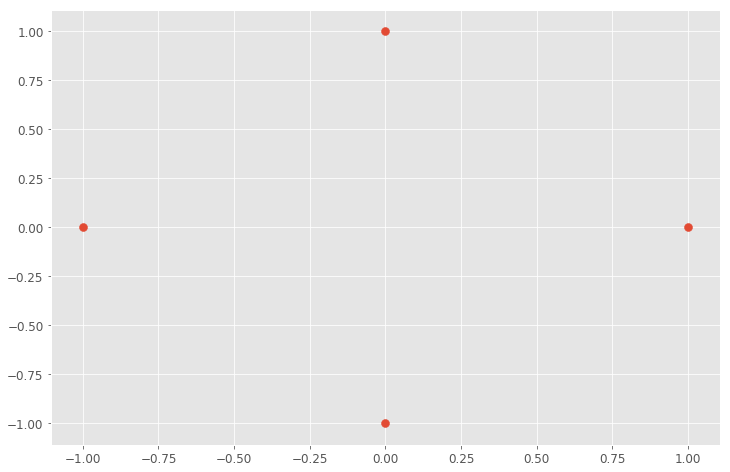

In [128]:
def generate_ellipse(dim, N, ellipse_M, is_uniform_sphere_random, jrandom_key): 

    # generate points on the sphere
    if is_uniform_sphere_random:
        dirs = jrandom.normal(jrandom_key, shape=(N, dim)) 
        dirs = dirs/jnp.linalg.norm(dirs, axis=1).reshape(-1, 1) * jnp.sqrt(dim)
    else:
        forwardX = jnp.eye(dim)
        backwardX = -jnp.eye(dim)

        num_dir_samples = N // (2 * dim)
        if num_dir_samples == 0:
            raise Exception("Given too few samples, {}, for Central Differences with dimension {}".format(N, dim))

        dirs = jnp.concatenate([jnp.tile(forwardX, (num_dir_samples, 1)), jnp.tile(backwardX, (num_dir_samples, 1))])

    # transform sphere to ellipse
    if ellipse_M is not None:
        L = jnp.linalg.cholesky(ellipse_M)
        dirs = dirs.dot(L.T)

    return dirs 


F = funcs["LogPolytope"](2)
N = 4
x_0 = x_0_generator(2)
ellipse_M = jnp.linalg.inv(F.f2(x_0.reshape(1, -1))[0])
circle_M = jnp.eye(2)
d = generate_ellipse(2, N, circle_M, False, jrandom_key_w)

# de = 
L  = jnp.linalg.cholesky(ellipse_M)
print(L.dot(L.T))
print(ellipse_M)
print(jnp.linalg.eigvals(ellipse_M))


plt.scatter(d[:, 0], d[:, 1])

[[0.3 0. ]
 [0.  2. ]]
[[-0.00333687  0.99999443]
 [ 0.99999443  0.00333687]]
[DeviceArray([19966.73511731+0.j,   450.71373076+0.j], dtype=complex128), DeviceArray([[ 0.99999802+0.j, -0.00198762+0.j],
             [ 0.00198762+0.j,  0.99999802+0.j]], dtype=complex128)]
0.2999997543291784
1.999999987066241


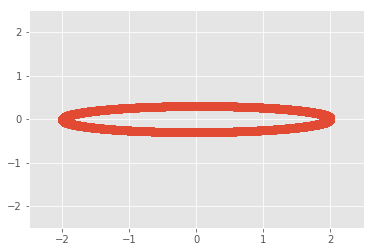

In [131]:


jrandom_key, subkey = jrandom.split(jrandom_key)
dim = 2
N = 10000
dirs = jrandom.normal(subkey, shape=(N, dim)) # sample gaussian and normalize 
ws = dirs
ws = dirs/jnp.linalg.norm(dirs, axis=1).reshape(-1, 1)
bs = jnp.ones(num_barriers)

jrandom_key, subkey = jrandom.split(jrandom_key)
A = jrandom.normal(subkey, shape=(dim, dim))
U, _, _ = jnp.linalg.svd(A)
S = jnp.diag(jnp.linspace(0.3, 2, dim))
print(S)
print(U)



ws = ws.dot(S.dot(U.T))

print(jnp.linalg.eig(ws.T.dot(ws)))
print(max(ws.dot(U[0])))
print(max(ws.dot(U[1])))

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)



plt.scatter(ws[:, 0], ws[:, 1])

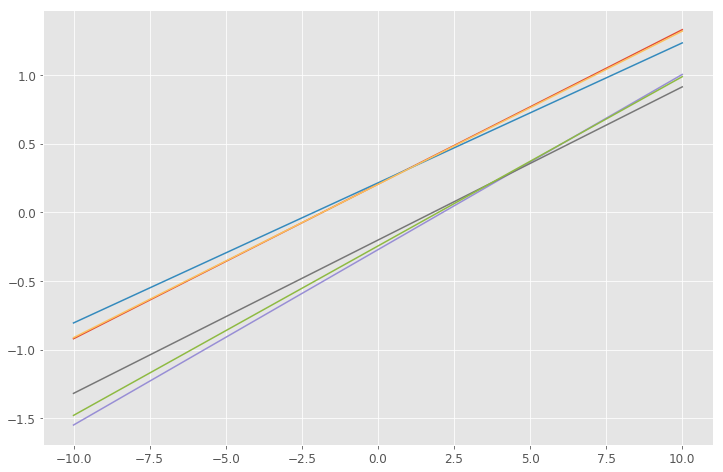

In [220]:
import numpy as np

# ======== Draw Domains ========
def get_endpoints(offset, v, box_length):
    """offset.shape = (d), v.shape = (d)
    return: 2"""
    cs = []
    for i in range(len(offset)):
        oi = offset[i]
        vi = v[i]
        if vi == 0:
            cs.append([np.inf, np.inf])
        else:
            cs.append([(box_length - oi)/vi, (-box_length - oi)/vi])
    cs = np.array(cs)
    min_idxs = np.argmin(np.abs(cs), axis=0)
    return [cs[:, i][min_idxs[i]] for i in range(len(cs))]

def draw_polytope(ws, bs, figure_size, ax):
    for i in range(len(ws)):
        w, b = ws[i], bs[i]
        v = np.array([-w[1], w[0]])
        offset = w * b / (np.linalg.norm(w)**2)
        c1, c2 = get_endpoints(offset, v, figure_size)
        x1, x2 = offset + c1*v, offset + c2*v
        X = np.array([x1, x2]).T
        ax.plot(X[0], X[1])

        
ax = plt.gca()
figure_size = 10

ws = jnp.array([[-0.55106409,  4.90185793],
             [-0.47748773,  4.68700401],
             [ 0.46774937, -3.66775659],
             [ 0.55009677, -4.93367387],
             [-0.55008842,  4.93382201],
             [ 0.50139867, -4.06929287]])

bs = jnp.ones(len(ws))

draw_polytope(ws, bs, figure_size, ax)